In [1]:
import pandas as pd 
import sys
import os 
from dotenv import load_dotenv


sys.path.append('C:\\Users\\Ourba\\Desktop\\10Academy\\10ac_week1_telecom_analysis\\src')
from loader import load_data


load_dotenv()

user = os.getenv('PG_USER')
password = os.getenv('PG_PASSWORD')
database_name = 'telecom'
table_name= 'xdr_data'
host = 'localhost'
port = '5432'

#Load data from Loader Module
df = load_data(host, port, user, password, database_name, table_name)
print(df.head())

      Bearer Id            Start  Start ms              End  End ms  \
0  1.311448e+19   4/4/2019 12:01     770.0  4/25/2019 14:35   662.0   
1  1.311448e+19   4/9/2019 13:04     235.0   4/25/2019 8:15   606.0   
2  1.311448e+19   4/9/2019 17:42       1.0  4/25/2019 11:58   652.0   
3  1.311448e+19   4/10/2019 0:31     486.0   4/25/2019 7:36   171.0   
4  1.311448e+19  4/12/2019 20:10     565.0  4/25/2019 10:40   954.0   

   Dur. (ms)          IMSI  MSISDN/Number          IMEI  \
0  1823652.0  2.082014e+14   3.366496e+10  3.552121e+13   
1  1365104.0  2.082019e+14   3.368185e+10  3.579401e+13   
2  1361762.0  2.082003e+14   3.376063e+10  3.528151e+13   
3  1321509.0  2.082014e+14   3.375034e+10  3.535661e+13   
4  1089009.0  2.082014e+14   3.369980e+10  3.540701e+13   

      Last Location Name  ...  Youtube DL (Bytes)  Youtube UL (Bytes)  \
0  9.16456699548519E+015  ...          15854611.0           2501332.0   
1                L77566A  ...          20247395.0          19111729.0   

In [2]:
from scipy import stats
import numpy as np
from utils import preproccess_numerical_data
preproccess_numerical_data(df)

numerical_cols = df.select_dtypes(include=['number']).columns

z_scores = stats.zscore(df[numerical_cols])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df = df[filtered_entries]
print(df[filtered_entries])

           Bearer Id            Start  Start ms              End     End ms  \
62      1.304243e+19   4/21/2019 2:55   73.0000   4/25/2019 0:17  262.00000   
65      1.311448e+19   4/21/2019 8:26  605.0000   4/25/2019 1:20  655.00000   
66      7.349883e+18   4/21/2019 8:54  105.0000   4/25/2019 0:48  931.00000   
67      1.311448e+19   4/21/2019 9:19  590.0000   4/25/2019 4:42  965.00000   
68      1.304243e+19  4/21/2019 10:09    1.0000   4/25/2019 1:39  272.00000   
...              ...              ...       ...              ...        ...   
149996  7.277826e+18   4/29/2019 7:28  451.0000   4/30/2019 6:02  214.00000   
149997  7.349883e+18   4/29/2019 7:28  483.0000  4/30/2019 10:41  187.00000   
149998  1.311448e+19   4/29/2019 7:28  283.0000  4/30/2019 10:46  810.00000   
149999  1.311448e+19   4/29/2019 7:28  696.0000  4/30/2019 10:40  327.00000   
150000  1.013887e+19             None  499.1882             None  498.80088   

            Dur. (ms)          IMSI  MSISDN/Number 

C:\Users\Ourba\AppData\Local\Temp\ipykernel_13672\3825670146.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(df[filtered_entries])


In [4]:
import pandas as pd

# Assuming df is your DataFrame containing the relevant columns
# Calculate session frequency per customer (MSISDN)
session_frequency = df.groupby('MSISDN/Number').size().reset_index(name='Session Frequency')

# Calculate session duration per customer (MSISDN) in milliseconds
session_duration = df.groupby('MSISDN/Number')['Dur. (ms)'].sum().reset_index(name='Session Duration (ms)')

# Calculate total session traffic (download + upload) per customer (MSISDN) in bytes
session_traffic = df.groupby('MSISDN/Number')[['Total UL (Bytes)', 'Total DL (Bytes)']].sum().sum(axis=1).reset_index(name='Total Session Traffic (Bytes)')

# Merge the aggregated metrics into a single DataFrame
engagement_metrics = pd.merge(session_frequency, session_duration, on='MSISDN/Number')
engagement_metrics = pd.merge(engagement_metrics, session_traffic, on='MSISDN/Number')

# Rank the customers based on each engagement metric
engagement_metrics['Rank - Session Frequency'] = engagement_metrics['Session Frequency'].rank(ascending=False)
engagement_metrics['Rank - Session Duration'] = engagement_metrics['Session Duration (ms)'].rank(ascending=False)
engagement_metrics['Rank - Total Session Traffic'] = engagement_metrics['Total Session Traffic (Bytes)'].rank(ascending=False)

# Report the top 10 customers for each engagement metric
top_10_frequency = engagement_metrics.sort_values(by='Rank - Session Frequency').head(10)
top_10_duration = engagement_metrics.sort_values(by='Rank - Session Duration').head(10)
top_10_traffic = engagement_metrics.sort_values(by='Rank - Total Session Traffic').head(10)

print("Top 10 Customers by Session Frequency:")
print(top_10_frequency[['MSISDN/Number', 'Session Frequency']])

print("\nTop 10 Customers by Session Duration:")
print(top_10_duration[['MSISDN/Number', 'Session Duration (ms)']])

print("\nTop 10 Customers by Total Session Traffic:")
print(top_10_traffic[['MSISDN/Number', 'Total Session Traffic (Bytes)']])


Top 10 Customers by Session Frequency:
       MSISDN/Number  Session Frequency
96320   4.188282e+10                899
34119   3.365973e+10                 11
68957   3.367588e+10                 10
63985   3.366907e+10                  9
23280   3.365043e+10                  9
1566    3.360658e+10                  9
28676   3.365836e+10                  8
36043   3.366025e+10                  8
13235   3.362695e+10                  8
53677   3.366519e+10                  8

Top 10 Customers by Session Duration:
       MSISDN/Number  Session Duration (ms)
96320   4.188282e+10           5.897111e+07
34119   3.365973e+10           2.578418e+06
68957   3.367588e+10           2.269343e+06
36116   3.366027e+10           1.943237e+06
52202   3.366475e+10           1.901398e+06
52096   3.366471e+10           1.770693e+06
68807   3.367557e+10           1.711214e+06
48908   3.366371e+10           1.659084e+06
14011   3.362845e+10           1.643561e+06
84942   3.376101e+10           1.607597e+0

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


# Assuming engagement_metrics is your DataFrame containing the engagement metrics
# Normalize the engagement metrics
scaler = StandardScaler()
normalized_metrics = scaler.fit_transform(engagement_metrics[['Session Frequency', 'Session Duration (ms)', 'Total Session Traffic (Bytes)']])

# Run k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
engagement_metrics['Cluster'] = kmeans.fit_predict(normalized_metrics)

# Analyze and interpret the clusters
cluster_summary = engagement_metrics.groupby('Cluster').mean().reset_index()

print("Cluster Summary:")
print(cluster_summary)

# Report the top 10 customers for each cluster
for cluster_id in range(3):
    print(f"\nTop 10 Customers in Cluster {cluster_id}:")
    print(engagement_metrics[engagement_metrics['Cluster'] == cluster_id].sort_values(by='Rank - Session Frequency').head(10)[['MSISDN/Number', 'Session Frequency']])


Cluster Summary:
   Cluster  MSISDN/Number  Session Frequency  Session Duration (ms)  \
0        0   3.367414e+10           2.500637           3.452038e+05   
1        1   4.188282e+10         899.000000           5.897111e+07   
2        2   3.367341e+10           1.141474           1.031908e+05   

   Total Session Traffic (Bytes)  Rank - Session Frequency  \
0                   1.282048e+09              13458.702212   
1                   4.443922e+11                  1.000000   
2                   5.595079e+08              53368.121260   

   Rank - Session Duration  Rank - Total Session Traffic  
0              7215.258157                  16706.937530  
1                 1.000000                      1.000000  
2             54304.854049                  52880.773491  

Top 10 Customers in Cluster 0:
       MSISDN/Number  Session Frequency
34119   3.365973e+10                 11
68957   3.367588e+10                 10
23280   3.365043e+10                  9
63985   3.366907e+10 

Cluster Summary:
   Cluster  Min Session Frequency  Max Session Frequency  \
0        0                      1                     11   
1        1                    899                    899   
2        2                      1                      4   

   Avg Session Frequency  Total Session Frequency  Min Session Duration  \
0               2.500637                    31423          8.555400e+04   
1             899.000000                      899          5.897111e+07   
2               1.141474                    95603          7.142000e+03   

   Max Session Duration  Avg Session Duration  Total Session Duration  \
0          2.578418e+06          3.452038e+05            4.337832e+09   
1          5.897111e+07          5.897111e+07            5.897111e+07   
2          3.021140e+05          1.031908e+05            8.642640e+09   

   Min Total Session Traffic  Max Total Session Traffic  \
0               6.010710e+07               5.179123e+09   
1               4.443922e+11  

C:\Users\Ourba\AppData\Local\Temp\ipykernel_13672\2793769387.py:28: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Metric', y='Value', hue='Cluster', data=plot_data, ci=None)


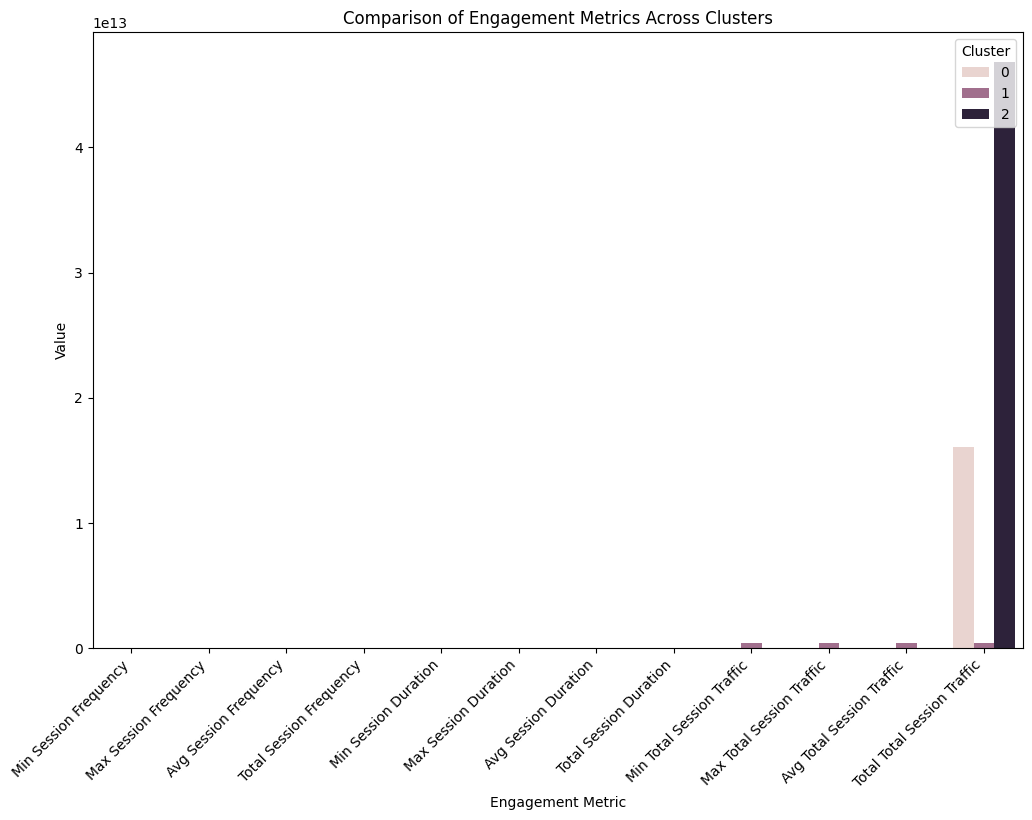

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate minimum, maximum, average, and total non-normalized metrics for each cluster
cluster_summary = engagement_metrics.groupby('Cluster').agg({
    'Session Frequency': ['min', 'max', 'mean', 'sum'],
    'Session Duration (ms)': ['min', 'max', 'mean', 'sum'],
    'Total Session Traffic (Bytes)': ['min', 'max', 'mean', 'sum']
}).reset_index()

# Rename columns for better readability
cluster_summary.columns = ['Cluster', 
                           'Min Session Frequency', 'Max Session Frequency', 'Avg Session Frequency', 'Total Session Frequency',
                           'Min Session Duration', 'Max Session Duration', 'Avg Session Duration', 'Total Session Duration',
                           'Min Total Session Traffic', 'Max Total Session Traffic', 'Avg Total Session Traffic', 'Total Total Session Traffic']

print("Cluster Summary:")
print(cluster_summary)

# Visualize the results
metrics = ['Session Frequency', 'Session Duration (ms)', 'Total Session Traffic (Bytes)']

# Reshape the data for plotting
plot_data = pd.melt(cluster_summary, id_vars=['Cluster'], var_name='Metric', value_name='Value')

# Plot grouped bar charts
plt.figure(figsize=(12, 8))
sns.barplot(x='Metric', y='Value', hue='Cluster', data=plot_data, ci=None)
plt.title('Comparison of Engagement Metrics Across Clusters')
plt.xlabel('Engagement Metric')
plt.ylabel('Value')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster', loc='upper right')
plt.show()


Cluster 0: This cluster seems to represent users with low to moderate engagement levels. The session frequency, duration, and total session traffic are relatively low compared to Cluster 2 but higher than Cluster 1.
Cluster 1: This cluster seems to represent users with unusually high and identical engagement levels across all metrics, which is suspicious and may indicate an issue with the clustering or aggregation process.
Cluster 2: This cluster seems to represent users with low engagement levels. The session frequency, duration, and total session traffic are the lowest among the three clusters.

In [28]:
import pandas as pd

# List of individual application columns
app_cols = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']

# Create new columns for total traffic per application
for app in app_cols:
    df[f'{app} Total Traffic (Bytes)'] = df[f'{app} DL (Bytes)'] + df[f'{app} UL (Bytes)']

# Aggregate total traffic per application for each user
user_traffic = df.groupby('MSISDN/Number')[[f'{app} Total Traffic (Bytes)' for app in app_cols]].sum().reset_index()

# Initialize an empty dictionary to store the top 10 most engaged users per application
top_10_users_per_app = {}

# Identify the top 10 most engaged users per application
for app in app_cols:
    top_10_users_per_app[app] = user_traffic.nlargest(10, f'{app} Total Traffic (Bytes)')[['MSISDN/Number', f'{app} Total Traffic (Bytes)']]

# Display the top 10 most engaged users per application
for app in app_cols[1:]:  # Start from Email and proceed to Other
    print(f"Top 10 Most Engaged Users for {app}:")
    print(top_10_users_per_app[app].head(10))
    

Top 10 Most Engaged Users for Google:
       MSISDN/Number  Google Total Traffic (Bytes)
96320   4.188282e+10                  6.884216e+09
1566    3.360658e+10                  8.549232e+07
34119   3.365973e+10                  8.110032e+07
68957   3.367588e+10                  7.950418e+07
23280   3.365043e+10                  7.871957e+07
69051   3.367608e+10                  7.197485e+07
2208    3.360816e+10                  6.947240e+07
48750   3.366367e+10                  6.934084e+07
53677   3.366519e+10                  6.816292e+07
56325   3.366616e+10                  6.748753e+07
Top 10 Most Engaged Users for Email:
       MSISDN/Number  Email Total Traffic (Bytes)
96320   4.188282e+10                 2.024785e+09
34119   3.365973e+10                 2.615407e+07
81641   3.369998e+10                 2.207753e+07
68957   3.367588e+10                 2.144987e+07
69051   3.367608e+10                 2.061025e+07
34783   3.365991e+10                 1.972068e+07
50910   3.3664

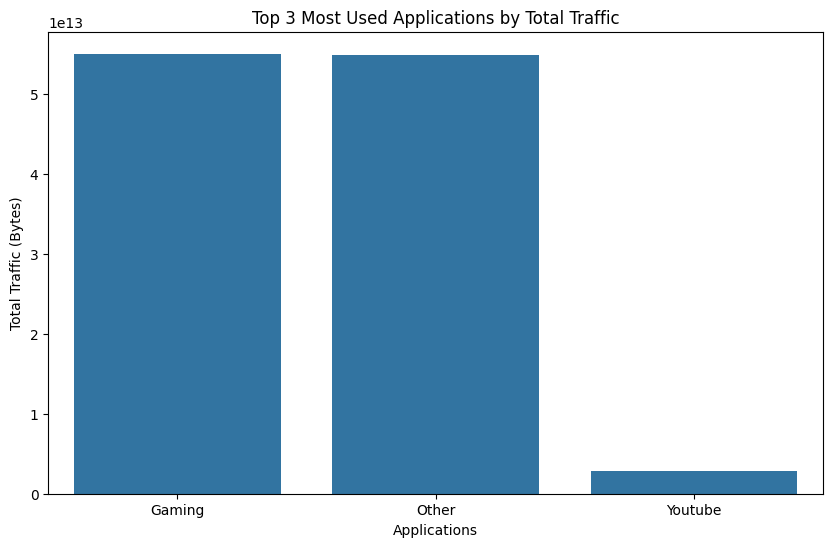

In [29]:



# Calculate the total traffic for each application
total_traffic_per_app = {app: df[f'{app} Total Traffic (Bytes)'].sum() for app in app_cols}

# Sort the applications based on total traffic in descending order
sorted_apps = sorted(total_traffic_per_app, key=total_traffic_per_app.get, reverse=True)

# Select the top 3 most used applications
top_3_apps = sorted_apps[:3]

# Create a bar plot for the top 3 most used applications
plt.figure(figsize=(10, 6))
sns.barplot(x=top_3_apps, y=[total_traffic_per_app[app] for app in top_3_apps])
plt.xlabel('Applications')
plt.ylabel('Total Traffic (Bytes)')
plt.title('Top 3 Most Used Applications by Total Traffic')
plt.show()


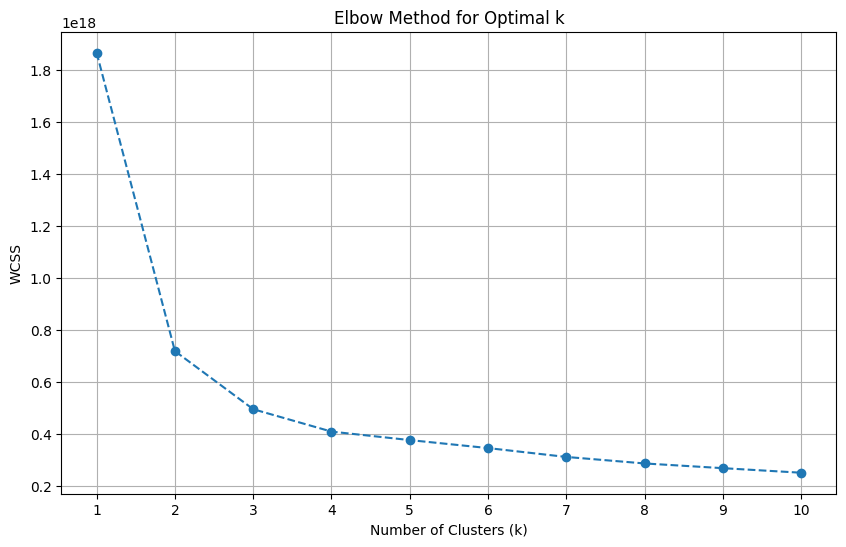

In [30]:
from sklearn.cluster import KMeans

# Select the engagement metrics for clustering
engagement_metrics = df[['Social Media Total Traffic (Bytes)', 'Google Total Traffic (Bytes)', 'Email Total Traffic (Bytes)']]

# Calculate WCSS for different values of k
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(engagement_metrics)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.xticks(np.arange(1, 11, 1))
plt.grid(True)
plt.show()
